# Compare success of different lineages
Natalia Vélez, July 2020

Now that we've built a graph representation of family trees, we'll use it to compare lineages and operationalize a success measure.

In [19]:
%matplotlib inline

import os, re, glob, datetime, json
from os.path import join as opj
import pandas as pd
import numpy as np
import scipy.stats
from tqdm import notebook

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

sns.set_context('talk')
sns.set_style('white')

## Set up data

Load lifelog data:

In [2]:
era_df = pd.read_csv('outputs/all_lifelogs_compact.tsv', sep='\t', index_col=0)
era_df.head()

/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,release,era,hash,playerID,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
0,342.0,boundless,2cdc4d0b016f9c0d96d27013f1d19c42596e0c5c,3080130,1592288229,3080111,[-454640 41],1592288538,[-454625 49],5.14,hunger,-454640,41,-454625,49,CLAUDINE,P
1,342.0,boundless,a8b5975a81344f690f45ffc2554a0bc35af557a9,3080128,1592288191,3080105,[-454394 -4],1592291791,[-454383 15],60.00,oldAge,-454394,-4,-454383,15,DACY,LIGHTNING
2,342.0,boundless,c5838da39fd525a2ac24aee049dae6a42e502236,3080125,1592288138,3080101,[-311131 -322],1592291738,[-311112 -325],59.98,hunger,-311131,-322,-311112,-325,SHOKO,GREATHOUSE
3,342.0,boundless,11f9fce50bbc1ebbba5126434aea123e79249942,3080122,1592288029,3080104,[-454638 41],1592288696,[-454647 58],11.12,hunger,-454638,41,-454647,58,RANGER,PICKLE
4,342.0,boundless,b265b1958566b474094cf0282a0fa59e6d622885,3080120,1592287917,3080101,[-311111 -311],1592291365,[-311115 -66],57.46,hunger,-311111,-311,-311115,-66,HAPPY,GREATHOUSE


Load families:

In [3]:
fam_df = pd.read_csv('outputs/family_playerID.tsv', sep='\t', index_col=0)
fam_df.head()

/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,playerID,family
0,6160151,time-1592284232_eve-3080067_name-PICKLE
1,6160181,time-1592284232_eve-3080067_name-PICKLE
2,6160178,time-1592284232_eve-3080067_name-PICKLE
3,6160175,time-1592284232_eve-3080067_name-PICKLE
4,6160171,time-1592284232_eve-3080067_name-PICKLE


Merge:

In [4]:
era_df = pd.merge(era_df, fam_df, on='playerID')

Just look at lineages from the boundless world era:

In [5]:
boundless_df = era_df[era_df['era'] == 'boundless'].copy().reset_index(drop=True)
boundless_families = np.unique(boundless_df['family'])

print(*boundless_families[:10], sep='\n')

time-1556920980_eve-1124142_name-ONEAL
time-1556921001_eve-1124146_name-SARAN
time-1556924751_eve-1124651_name-WATERS
time-1556925978_eve-1124801_name-HAAK
time-1556931561_eve-1125556_name-HAAK
time-1556935005_eve-1125960_name-TRIPLET
time-1556935718_eve-1126030_name-RAVEN
time-1556935718_eve-1126031_name-SPARROW
time-1556935718_eve-1126032_name-CROW
time-1556935922_eve-1126066_name-JO


In [6]:
lineage_df = era_df.copy()
lineage_df = lineage_df[lineage_df['family'].isin(boundless_families)].reset_index(drop=True)
lineage_df.head()

,release,era,hash,playerID,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last,family
0,342.0,boundless,2cdc4d0b016f9c0d96d27013f1d19c42596e0c5c,3080130,1592288229,3080111,[-454640 41],1592288538,[-454625 49],5.14,hunger,-454640,41,-454625,49,CLAUDINE,P,time-1559994101_eve-1539537_name-GOUL
1,342.0,boundless,2681fd11744e90e24d37b56c4cc016fd86c9438a,3080090,1592284897,3080061,[-454390 7],1592288493,[-454373 7],59.94,hunger,-454390,7,-454373,7,TOIA,LIGHTNING,time-1559975927_eve-1537506_name-DROVER
2,342.0,boundless,49d985b1c4e5716ec2cbcdb857b00df01bd2ac79,3080036,1592282641,3079986,[-312633 -232],1592286198,[-312645 -238],59.30,hunger,-312633,-232,-312645,-238,BABY,TEA,time-1559975927_eve-1537506_name-DROVER
3,342.0,boundless,dce3a4fb6c10feb52c169e48e85bb4e7dfea1514,3079966,1592279149,3079910,[-312642 -239],1592282749,[-312633 -231],60.00,oldAge,-312642,-239,-312633,-231,SADA,TEA,time-1559975927_eve-1537506_name-DROVER
4,342.0,boundless,b4d68bc327c96fbee1fcf907b7d1738f100d4fe9,3079939,1592278284,3079924,[-311121 -322],1592280224,[-311203 -320],32.32,hunger,-311121,-322,-311203,-320,TAN,GREATHOUSE,time-1559994101_eve-1539537_name-GOUL


In [7]:
t_fmt = '%Y-%m-%dT%H:%M:%S %Z'

start_t = np.min(lineage_df['tBirth'])
start_date = datetime.datetime.fromtimestamp(start_t).strftime(t_fmt)

end_t = np.max(lineage_df['tDeath'])
end_date = datetime.datetime.fromtimestamp(end_t).strftime(t_fmt)

print('Analyzing %i lineages' % len(boundless_families))
print('First lineage starts at: %s' % start_date)
print('Lineages end at: %s' % end_date)

Analyzing 4737 lineages
First lineage starts at: 2019-11-07T16:42:38 
Lineages end at: 2020-06-15T23:22:18 


## Compute summary statistics

### Family size and life expectancy

[Text(0.5, 0, 'Life expectancy by family')]

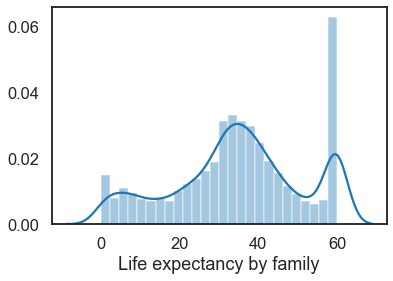

In [8]:
life_expectancy = lineage_df.groupby('family')['age'].agg(['mean', 'count']).reset_index()
ax = sns.distplot(life_expectancy['mean'])
ax.set(xlabel = 'Life expectancy by family')

[Text(0.5, 0, 'Total family size')]

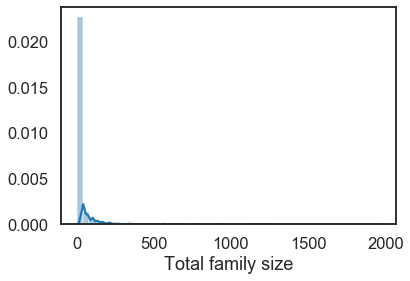

In [9]:
ax = sns.distplot(life_expectancy['count'])
ax.set(xlabel = 'Total family size')

In [21]:
scipy.stats.mode(life_expectancy['count'])

ModeResult(mode=array([1]), count=array([1550]))

[None, Text(0, 0.5, 'Family size'), Text(0.5, 0, 'Life expectancy')]

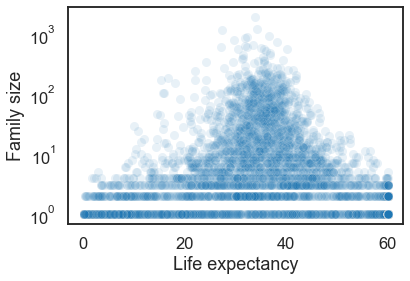

In [10]:
ax = sns.scatterplot(data=life_expectancy, x = 'mean', y = 'count', alpha = 0.1)
ax.set(yscale='log', xlabel='Life expectancy', ylabel='Family size')

### Living population size over time

In [11]:
living_list = []
for fam in notebook.tqdm(boundless_families):
    fam_df = lineage_df[lineage_df['family'] == fam].copy().reset_index(drop=True)
    t = fam_df['tBirth'].values
    for ti in t:
        is_alive = (fam_df['tBirth'] <= ti) & (fam_df['tDeath'] > ti)
        pop = np.sum(is_alive)
        living_list.append((fam, ti, pop))

In [12]:
living_df = pd.DataFrame(living_list, columns = ['family', 't', 'population'])
living_df = living_df.sort_values(by=['family', 't'], ascending=True).reset_index(drop=True)
living_df['t0'] = living_df.groupby('family')['t'].transform('first')
living_df['t_elapsed'] = (living_df['t'] - living_df['t0'])/60/60
living_df.head()

,family,t,population,t0,t_elapsed
0,time-1556920980_eve-1124142_name-ONEAL,1573173894,1,1573173894,0.000000
1,time-1556920980_eve-1124142_name-ONEAL,1573175281,1,1573173894,0.385278
2,time-1556920980_eve-1124142_name-ONEAL,1573176140,1,1573173894,0.623889
3,time-1556920980_eve-1124142_name-ONEAL,1573178439,1,1573173894,1.262500
4,time-1556920980_eve-1124142_name-ONEAL,1573180901,1,1573173894,1.946389


Plot a subset

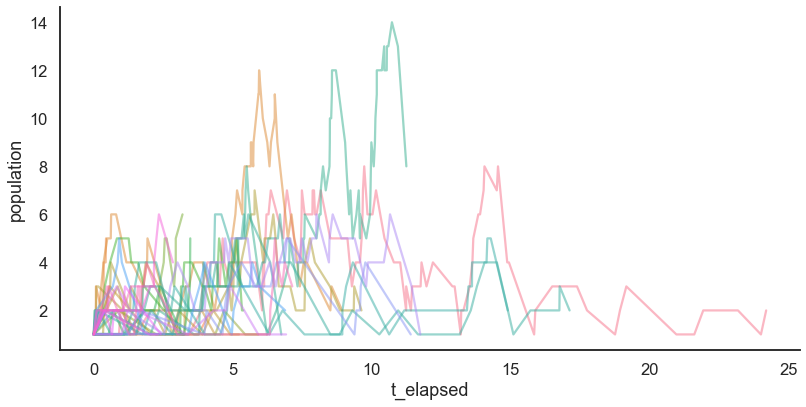

In [13]:
random_families = np.random.choice(boundless_families, size=50, replace=False)
random_subset = living_df[living_df['family'].isin(random_families)]
g = sns.relplot(data=random_subset, x='t_elapsed', y='population', hue='family', kind='line',
                 height=6, aspect=2, alpha = 0.5)
g._legend.remove()

Maximum population size

[Text(0.5, 0, 'Maximum living population size')]

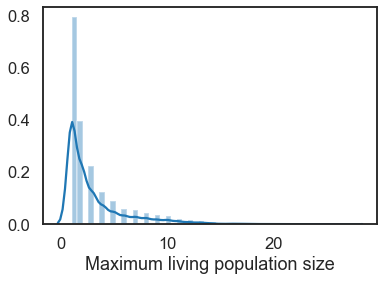

In [14]:
max_pop = living_df.groupby('family')['population'].agg('max').reset_index()
ax = sns.distplot(max_pop['population'])
ax.set(xlabel = 'Maximum living population size')

In [23]:
scipy.stats.mode(max_pop['population'])

ModeResult(mode=array([1]), count=array([1953]))

### Chain length

Helper: Read JSON files

In [15]:
def open_graph(f):
    with open(f) as handle:
        graph_data = json.load(handle)
    return nx.json_graph.node_link_graph(graph_data)

Find longest chain in family graphs

In [16]:
chain_list = []

for f in notebook.tqdm(boundless_families):
    fam_file = 'outputs/families/families_%s.json' % f
    fam_graph = open_graph(fam_file)
    fam_chain = nx.algorithms.dag_longest_path(fam_graph)
    chain_list.append((f, len(fam_chain)))

In [17]:
chain_df = pd.DataFrame(chain_list, columns=['family', 'chain'])
chain_df.head()

,family,chain
0,time-1556920980_eve-1124142_name-ONEAL,21
1,time-1556921001_eve-1124146_name-SARAN,21
2,time-1556924751_eve-1124651_name-WATERS,17
3,time-1556925978_eve-1124801_name-HAAK,16
4,time-1556931561_eve-1125556_name-HAAK,6


In [20]:
scipy.stats.mode(chain_df['chain'])

ModeResult(mode=array([2]), count=array([2412]))

[Text(0.5, 0, '# of generations')]

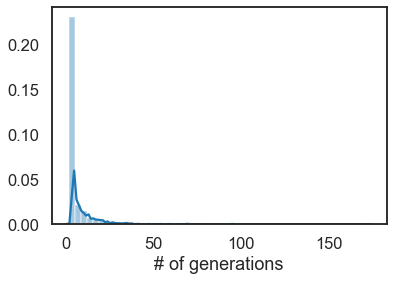

In [18]:
ax = sns.distplot(chain_df['chain'])
ax.set(xlabel = '# of generations')

## Modeling success

Criterion for "success": Reaching age 14 (viability fitness)

In [28]:
mortality_df = lineage_df.copy()
mortality_df['adult'] = lineage_df['age'] >= 14
mortality_df = mortality_df.groupby('family')['adult'].agg(['sum', 'count']).reset_index()
mortality_df['sum'] = mortality_df['sum'].astype(np.int)
mortality_df.head()

,family,sum,count
0,time-1556920980_eve-1124142_name-ONEAL,39,79
1,time-1556921001_eve-1124146_name-SARAN,34,64
2,time-1556924751_eve-1124651_name-WATERS,29,55
3,time-1556925978_eve-1124801_name-HAAK,36,83
4,time-1556931561_eve-1125556_name-HAAK,1,8


Compute beta distribution for each family

Prior: Uniform
$$
\theta \sim \mathrm{Beta}(\alpha_0, \beta_0) \\
\alpha_0 = \beta_0 = 1
$$

Posterior-sufficient statistics:
$$
\theta | D \sim \mathrm{Beta}(\alpha_0 + k, \beta_0 + N - k) \\ 
a = \alpha_0 + k \\
b = \beta_0 + N - k
$$

In [33]:
def beta_mean(row): return scipy.stats.beta.mean(row['a'], row['b'])
def beta_var(row): return scipy.stats.beta.var(row['a'], row['b'])

mortality_df['a'] = 1 + mortality_df['sum']
mortality_df['b'] = 1 + mortality_df['count'] - mortality_df['sum']
mortality_df['beta_mean'] = mortality_df.apply(beta_mean, axis=1)
mortality_df['beta_var'] = mortality_df.apply(beta_var, axis=1)
mortality_df['snr'] = mortality_df['beta_mean']/mortality_df['beta_var']
mortality_df.head()

,family,sum,count,a,b,beta_mean,beta_var,snr
0,time-1556920980_eve-1124142_name-ONEAL,39,79,40,41,0.493827,0.003048,162.000000
1,time-1556921001_eve-1124146_name-SARAN,34,64,35,31,0.530303,0.003718,142.645161
2,time-1556924751_eve-1124651_name-WATERS,29,55,30,27,0.526316,0.004298,122.444444
3,time-1556925978_eve-1124801_name-HAAK,36,83,37,48,0.435294,0.002858,152.291667
4,time-1556931561_eve-1125556_name-HAAK,1,8,2,8,0.200000,0.014545,13.750000


Beta mean:

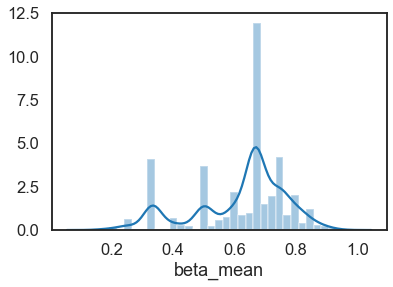

In [43]:
ax = sns.distplot(mortality_df['beta_mean'])

Distribution of SNR:

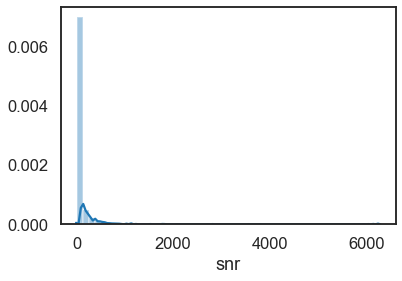

In [42]:
ax = sns.distplot(mortality_df['snr'])

In [41]:
scipy.stats.mstats.mquantiles(mortality_df['snr'], prob = [0, .2, .4, .6, .8, 1])

array([6.00000000e+00, 1.20000000e+01, 1.20000000e+01, 2.10000000e+01,
       6.64285714e+01, 6.26762075e+03])